In [2]:
!pip install torchsummary

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!conda install -c anaconda diffusers-torch

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::aiohttp==3.8.3=py311h5eee18b_0
  - conda-forge/linux-64::deepspeed==0.9.5=cpu_py311h057d117_0
  - pytorch/noarch::ignite==0.4.12=py_0
  - pytorch/linux-64::torchvision==0.15.2=py311_cu118
  - conda-forge/noarch::accelerate==0.21.0=pyhd8ed1ab_0
  - defaults/linux-64::huggingface_hub==0.15.1=py311h06a4308_0
  - pytorch/linux-64::torchaudio==2.0.2=py311_cu118
  - defaults/linux-64::mkl_fft==1.3.6=py311ha02d727_1
  - defaults/linux-64::datasets==2.12.0=py311h06a4308_0
  - conda-forge/noarch::transformers==4.28.1=pyhd8ed1ab_0
  - defaults/linux-64::bottleneck==1.3.5=py311hbed6279_0
  - defaults/linux-64::numexpr==2.8.4=py311h65dcdc2_1
  - defaults/linux-64::scipy==1.11.1=py311h08b1b3b_0
  - defaults/linux-64::pandas==2.0.3=py311ha02d727_0
  - defaults/linux-64::nltk==3.8.1=py311h06a4308_0
  - defaults/linux-64::pyarrow

In [27]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*(x-0.5))
    #transforms.Lambda(lambda x: x*2 - 1)
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

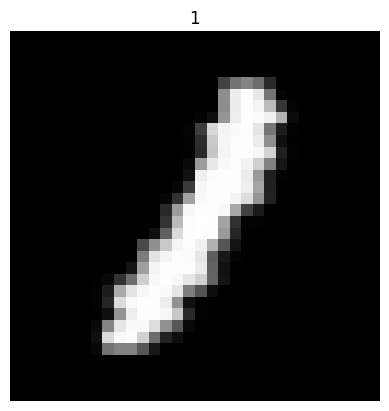

In [29]:
# Show example
for i in train_loader:
  x, y = i
  plt.imshow(x[1][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[1].numpy())
  break

In [30]:
import diffusers
from tqdm.auto import tqdm

model = diffusers.UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(128,128,256),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)

In [32]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [39]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, net, D, sigma=0.001, tmin=1e-10, xmin=-1, xmax=1):
        super(BayesianFlowNetwork2D, self).__init__()
        self.sigma = torch.tensor(sigma)
        self.D = D
        self.t_min = tmin
        self.xmin = xmin
        self.xmax = xmax
        self.net = net

    def forward(self, mu, t, ema):
        if ema is not None:
          with ema.average_parameters():
            output = self.net(mu,t)['sample']  # (B, D, D, K)
        else:
          output = self.net(mu,t)['sample']  # (B, D, D, K)

        return output

    def CTS_OUTPUT_PREDICTION(self, mu, t, gamma,ema=None):
        eps_hat = self.forward(mu, t, ema=ema)
        mask = t>=self.t_min
        eps_hat = eps_hat*mask[:,None,None,None]
        x_hat = (mu/gamma[:, None, None, None]) - ((1-gamma[:, None, None, None])/gamma[:, None, None, None]).sqrt()*eps_hat
        x_hat = torch.clip(x_hat,self.xmin,self.xmax)
        return x_hat

    def process(self, x, t=None, training=True):

        # Step 1: Sample t from U(0, 1)
        if t is None:
          t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        else:
          t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

        # Step 2: Calculate gamma
        gamma = 1- self.sigma**(2*t)  # (B,


        # Step 3: Sample mu from N(gamma*X, gamma*(1-gamma)*I)
        mean = gamma[:, None, None, None] * (x)
        std = torch.sqrt(gamma*(1-gamma))
        eps = torch.randn_like(mean)
        mu = mean + std[:, None, None, None] * eps

        # Step 5: CTS_OUTPUT_PREDICTION
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, gamma)  # (B, K, D, D)
       

        L_infinity = -torch.log(self.sigma)*(self.sigma**(-2*t[:, None, None, None]))*((x - x_hat) ** 2)

        if training:
          return L_infinity.mean()
        else:
          return L_infinity.mean(), mu, t

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=100, ema=None, device='cpu'):
        self.eval()
        mu = torch.zeros((batch_size, 1, self.D, self.D), device=device)
        rho = 1

        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            if t<1e-7:
              t+=1e-7
            t = t * torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)

            x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, 1- self.sigma**(2*t))  # (B, D, D, K)
            alpha = (self.sigma**((-2 * i)/nb_steps))*(1-self.sigma**(2/nb_steps))
            std = torch.sqrt(1/alpha)
            eps = torch.randn_like(x_hat)
            y = x_hat + std * eps  # (B, D, D, K)

            mu = (rho*mu + alpha*y)/(rho+alpha)
            rho = rho+alpha
        t_final = torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t_final, 1- self.sigma**(2*t_final))
        return x_hat

In [40]:
from torch.optim import AdamW

bfn = BayesianFlowNetwork2D(model, 32).to(device)
#bfn = MyUNet()
#ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)

# bfn.cuda()
#ema.to(device)

optim = AdamW(bfn.parameters(), lr=0.0002, betas=(0.9, 0.98), weight_decay=0.01)


Epoch 1/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


1.1424495719246945


Epoch 2/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


1.0403257189160686


Epoch 3/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.9977448060687653


Epoch 4/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.973162185590146


Epoch 5/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.9565245339425944


Epoch 6/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.9438082668404121


Epoch 7/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.9340332768153914


Epoch 8/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.9257665584653111


Epoch 9/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.918359807767886


Epoch 10/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.9126111728660131


Epoch 11/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.9070429886434405


Epoch 12/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.9018383991751967


Epoch 13/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.897262493354867


Epoch 14/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8929236391987697


Epoch 15/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8890474530263136


Epoch 16/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8853821222812442


Epoch 17/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8820500583021139


Epoch 18/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8788328751669092


Epoch 19/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8760135478467201


Epoch 20/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8732550580117662


Epoch 21/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8704585255491243


Epoch 22/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8679636140541964


Epoch 23/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8655970737876133


Epoch 24/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8632526754659448


Epoch 25/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8610050033310712


Epoch 26/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8588440098460992


Epoch 27/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8567706675029594


Epoch 28/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8547848707322059


Epoch 29/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8529616809253592


Epoch 30/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.8512578323736029


Epoch 31/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8495308560644622


Epoch 32/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8477850262770208


Epoch 33/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8461674194367775


Epoch 34/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8445221313748023


Epoch 35/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8429817641618466


Epoch 36/100: 100%|██████████| 59/59 [00:34<00:00,  1.74it/s]


0.841416240468088


Epoch 37/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8400288044832958


Epoch 38/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.838599538159732


Epoch 39/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8373139221375012


Epoch 40/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8359216763811597


Epoch 41/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8345642035881711


Epoch 42/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.8333541051671811


Epoch 43/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8321893029105818


Epoch 44/100: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.83098235049031


Epoch 45/100: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.8298542354515492


Epoch 46/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8286364111684225


Epoch 47/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8275352111801618


Epoch 48/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.8264634555132039


Epoch 49/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8254304504732655


Epoch 50/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8243906058295298


Epoch 51/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8234128161853792


Epoch 52/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8222894369584485


Epoch 53/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8213726982622052


Epoch 54/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8204529484861389


Epoch 55/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8194910963621271


Epoch 56/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8185451112092262


Epoch 57/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.817644690496029


Epoch 58/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8167362729232259


Epoch 59/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8158881768896743


Epoch 60/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8150674207230746


Epoch 61/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8141977943026645


Epoch 62/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8133488856846678


Epoch 63/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8125444067432126


Epoch 64/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8117756524233747


Epoch 65/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8109297661458031


Epoch 66/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8101983312680039


Epoch 67/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8094376741166118


Epoch 68/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8086586283930277


Epoch 69/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8079268417555178


Epoch 70/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8072520145781104


Epoch 71/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.8065272807420424


Epoch 72/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8058339279502799


Epoch 73/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8051172521735998


Epoch 74/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8044983112123981


Epoch 75/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.8038287780379172


Epoch 76/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8031362195986919


Epoch 77/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.8024927189952079


Epoch 78/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8018485777847459


Epoch 79/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8012268791329679


Epoch 80/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.8005931202385386


Epoch 81/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.7999971252551361


Epoch 82/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.799382455317429


Epoch 83/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.7987722549629328


Epoch 84/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7982029303535518


Epoch 85/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.7976220357453716


Epoch 86/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.7970156290186264


Epoch 87/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7964092307961198


Epoch 88/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.7958244727737914


Epoch 89/100: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]


0.7953168013122645


Epoch 90/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7947327510897498


Epoch 91/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7942251719716187


Epoch 92/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7936720165397283


Epoch 93/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7931296453789672


Epoch 94/100: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.7925974182647529


Epoch 95/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.7920748846111927


Epoch 96/100: 100%|██████████| 59/59 [00:34<00:00,  1.74it/s]


0.7915663592685751


Epoch 97/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7910271810314652


Epoch 98/100: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


0.7905541904881437


Epoch 99/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


0.7900162099710252


Epoch 100/100: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]

0.7895008864645231


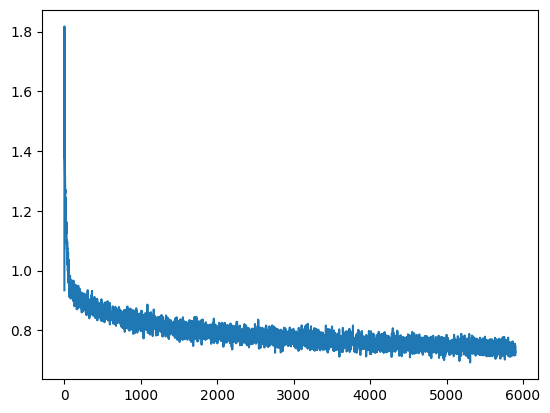

In [41]:
losses = []

epochs = 100
best_loss = 10000
k = 0
early_stopping = False
patience = 1e6
J = 0
for i in range(epochs):
  for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}"):
      optim.zero_grad()

      loss = bfn.process(X.to(device))
      loss.backward()

      optim.step()

      losses.append(loss.item())

      # if (J+1)%100 == 0:
        # print(loss)
      J+=1

      if loss.item() < best_loss:
        best_loss = loss.item()
        k = 0
      else:
        k += 1
        if k == patience:
          k = 0
          early_stopping = True
          break
  print(sum(losses)/len(losses))
  if early_stopping:
    break


plt.plot(losses)

(0.0, 0.1)

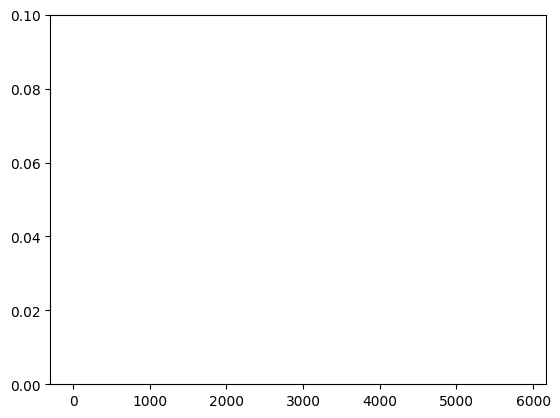

In [42]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

plt.plot(moving_average(losses, 20))
plt.ylim(0, 0.1)

In [43]:
x_hat = bfn.sample(device='cuda:2', nb_steps=1000, batch_size=16)

100%|██████████| 1000/1000 [00:07<00:00, 130.95it/s]


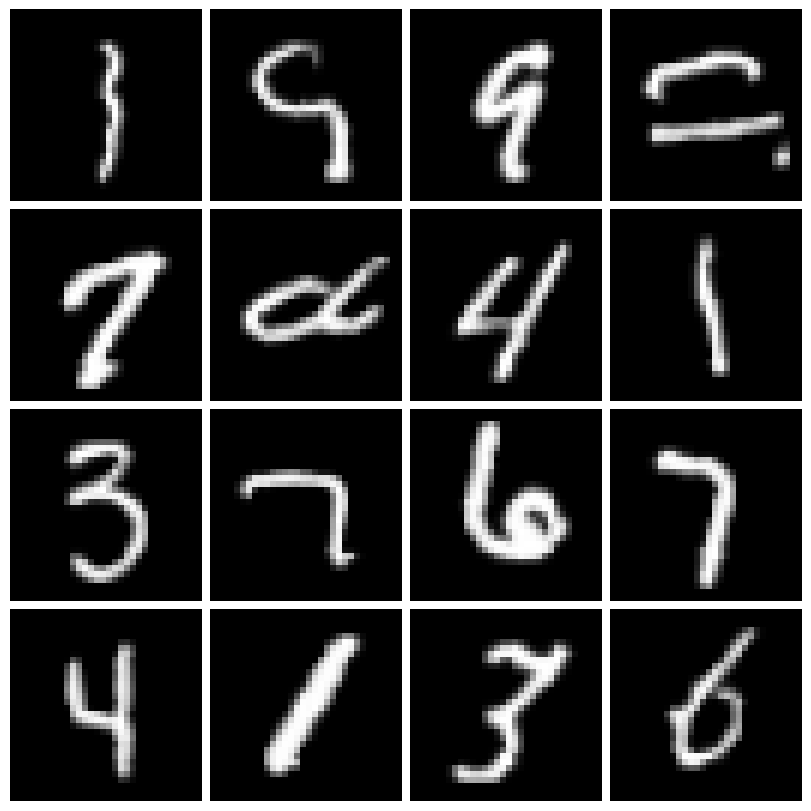

In [44]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i][0], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

tensor([218, 782, 803])